In [ ]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset & DataLoader

In [ ]:
_act_func = {
    "relu": nn.ReLU(),
    "lrelu": nn.LeakyReLU(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
    "elu": nn.ELU(),
    "selu": nn.SELU(),
    "softmax": nn.Softmax(1),
    "lsoftmax": nn.LogSoftmax(1)
}


def linear_block(n_in, n_out, batch_norm=False, activation='relu', dropout=0.):
    """
    available activation {relu, lrelu, sigmoid, tanh, elu, selu, softmax, lsoftmax}
    """
    layers = [nn.Linear(n_in, n_out)]

    if batch_norm:
        layers.append(nn.BatchNorm1d(n_out))

    if activation in _act_func:
        layers.append(_act_func[activation])
    else:
        raise Exception(f"jcopdl supports ({', '.join(_act_func.keys())})")

    if 0 < dropout <= 1:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)


def conv_block(c_in, c_out, kernel=3, stride=1, pad=1, pool_type='max', pool_kernel=3, pool_stride=2,
               batch_norm=False, activation='relu', dropout=True):
    """
    available activation {relu, lrelu, sigmoid, tanh, elu, selu, softmax, lsoftmax}
    available pool_type {max, avg}
    """
    layers = [nn.Conv2d(c_in, c_out, kernel_size=kernel, stride=stride, padding=pad)]


    if dropout == True:
      layers.append(nn.Dropout2d(p=0.1, inplace=False))

    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))

    if activation in _act_func:
        layers.append(_act_func[activation])
    else:
        raise Exception(f"jcopdl supports ({', '.join(_act_func.keys())})")

    if pool_type == "max":
        layers.append(nn.MaxPool2d(pool_kernel, pool_stride))
    elif pool_type == "avg":
        layers.append(nn.AvgPool2d(pool_kernel, pool_stride))
    elif pool_type is None:
        pass
    else:
        raise Exception("jcopdl supports (max, avg)")
    return nn.Sequential(*layers)

In [ ]:
import os


class Callback:

    def __init__(self, model, config=None, save_every=50, early_stop_patience=30,
                 plot_every=20, outdir="model"):
        self.save_every = save_every
        self.early_stop_patience = early_stop_patience
        self.plot_every = plot_every
        self.outdir = outdir

        self.ckpt = Checkpoint(model, config)
        os.makedirs(self.outdir, exist_ok=True)

    def save_checkpoint(self):
        if self.ckpt.epoch % self.save_every == 0:
            self._save("checkpoint")

    def early_stopping(self, model, monitor='test_score', load_best_when_stop=True):
        stop = False
        if monitor == "train_cost":
            reference = self.ckpt.train_cost[-1]
            improve = reference < self.ckpt.best_cost
        elif monitor == "test_cost":
            reference = self.ckpt.test_cost[-1]
            improve = reference < self.ckpt.best_cost
        elif monitor == "train_score":
            reference = self.ckpt.train_score[-1]
            improve = reference > self.ckpt.best_score
        elif monitor == "test_score":
            reference = self.ckpt.test_score[-1]
            improve = reference > self.ckpt.best_score
        else:
            raise Exception('Only supports monitor={"train_cost", "test_cost", "train_score", "test_score"}')

        if improve:
            if monitor.endswith("_cost"):
                self.ckpt.best_cost = reference
            elif monitor.endswith("_score"):
                self.ckpt.best_score = reference
            self.ckpt.weights = model.state_dict().copy()
            self.reset_early_stop()
            self._save("best")
        else:
            self.ckpt.early_stop += 1
            best = self.ckpt.best_cost if monitor.endswith("_cost") else self.ckpt.best_score
            print(f"\x1b[31m==> EarlyStop patience = {self.ckpt.early_stop:2} | Best {monitor}: {best:.4f}\x1b[0m")

            if self.ckpt.early_stop >= self.early_stop_patience:
                print(f'\x1b[31m==> Execute Early Stopping at epoch: {self.ckpt.epoch} | Best {monitor}: {best:.4f}\x1b[0m')
                print(f'\x1b[31m==> Best model is saved at {self.outdir}\x1b[0m')
                stop = True

                if load_best_when_stop:
                    weights = torch.load(f'{self.outdir}/weights_best.pth', map_location="cpu")
                    model.load_state_dict(weights)

        self.next_epoch()
        return stop

    def cost_runtime_plotting(self, scale="semilogy", figsize=(8, 5)):
        if self.ckpt.epoch % self.plot_every == 0:
            self._plot(scale, figsize, mode="Cost")

    def score_runtime_plotting(self, scale="linear", figsize=(8, 5)):
        if self.ckpt.epoch % self.plot_every == 0:
            self._plot(scale, figsize, mode="Score")

    def plot_cost(self, scale="semilogy", figsize=(8, 5)):
        self._plot(scale, figsize, mode="Cost")

    def plot_score(self, scale="linear", figsize=(8, 5)):
        self._plot(scale, figsize, mode="Score")

    def log(self, train_cost=None, test_cost=None, train_score=None, test_score=None):
        report = f'\nEpoch {self.ckpt.epoch:5}\n'
        if train_cost is not None:
            train_cost = train_cost.item() if type(train_cost) == torch.Tensor else train_cost
            self.ckpt.train_cost.append(train_cost)
            report += f'Train_cost  = {train_cost:.4f} | '
        if test_cost is not None:
            test_cost = test_cost.item() if type(test_cost) == torch.Tensor else test_cost
            self.ckpt.test_cost.append(test_cost)
            report += f'Test_cost  = {test_cost:.4f} | '
        if train_score is not None:
            train_score = train_score.item() if type(train_score) == torch.Tensor else train_score
            self.ckpt.train_score.append(train_score)
            report += f'Train_score = {train_score:.4f} | '
        if test_score is not None:
            test_score = test_score.item() if type(test_score) == torch.Tensor else test_score #jika ya ubh ke skalar
            self.ckpt.test_score.append(test_score)
            report += f'Test_score = {test_score:.4f} |'

        self.ckpt.plot_tick.append(self.ckpt.epoch)
        print(report)

    def next_epoch(self):
        self.ckpt.epoch += 1

    def reset_early_stop(self):
        self.ckpt.early_stop = 0

    def _plot(self, scale, figsize, mode):
        plot_func = self._plot_func(scale)

        plt.figure(figsize=figsize)
        plt.ylabel(mode)
        plt.xlabel("Epoch")
        if mode == "Cost":
            plot_func(self.ckpt.plot_tick, self.ckpt.train_cost, 'r-', label="Train")
            if self.ckpt.test_cost != []:
                plot_func(self.ckpt.plot_tick, self.ckpt.test_cost, 'b-', label="Test")
        elif mode == "Score":
            plot_func(self.ckpt.plot_tick, self.ckpt.train_score, 'r-', label="Train")
            if self.ckpt.test_score != []:
                plot_func(self.ckpt.plot_tick, self.ckpt.test_score, 'b-', label="Test")
        plt.legend()
        plt.show();

    def _save(self, mode):
        # Save weights
        weights = self.ckpt.weights
        if mode == "checkpoint":
            torch.save(weights, f'{self.outdir}/weights_{self.ckpt.epoch}.pth')
        elif mode == "best":
            torch.save(weights, f'{self.outdir}/weights_best.pth')

        # Save config if exist
        if self.ckpt.config is not None:
            configs = self.ckpt.config
            torch.save(configs, f'{self.outdir}/configs.pth')

        # Save logs
        logs = self._parse_logs()
        torch.save(logs, f'{self.outdir}/logs.pth')

    def _parse_logs(self):
        logs = {
            "plot_tick": self.ckpt.plot_tick
        }
        if self.ckpt.best_cost < np.inf:
            logs["best_cost"] = self.ckpt.best_cost
        if self.ckpt.best_score > 0:
            logs["best_score"] = self.ckpt.best_score

        if self.ckpt.train_cost != []:
            logs["train_cost"] = self.ckpt.train_cost
        if self.ckpt.train_score != []:
            logs["train_score"] = self.ckpt.train_score

        if self.ckpt.test_cost != []:
            logs["test_cost"] = self.ckpt.test_cost
        if self.ckpt.test_score != []:
            logs["test_score"] = self.ckpt.test_score
        return logs

    @staticmethod
    def _plot_func(scale):
        if scale == "linear":
            plot_func = plt.plot
        elif scale == "semilogx":
            plot_func = plt.semilogx
        elif scale == "semilogy":
            plot_func = plt.semilogy
        elif scale == "loglog":
            plot_func = plt.loglog
        else:
            raise Exception('Only supports scale={"linear", "semilogx", "semilogy", "loglog"}')
        return plot_func


class Checkpoint:
    def __init__(self, model, config):
        self.train_cost = []
        self.test_cost = []
        self.train_score = []
        self.test_score = []
        self.plot_tick = []
        self.best_cost = np.inf
        self.best_score = 0
        self.weights = model.state_dict()
        self.epoch = 1
        self.early_stop = 0
        self.config = config



class Config:
    def __init__(self):
        pass

    def __repr__(self):
        params = [f"{k}={v}" for k, v in sorted(self.__dict__.items())]
        return f"Config({', '.join(params)})"


def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config


In [ ]:
bs = 64
crop_size = 224

train_transform = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])


test_transform = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_set = datasets.ImageFolder("/content/drive/MyDrive/UAS AI/Dataset/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("/content/drive/MyDrive/UAS AI/Dataset/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
feature, target = next(iter(trainloader))
feature.shape # 3 rgb

torch.Size([64, 3, 224, 224])

In [ ]:
label2cat = train_set.classes
label2cat

['cloth', 'n95', 'n95v', 'nfm', 'srg']

## Arsitektur dan Config

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 64, batch_norm=True, pool_kernel=3),
            conv_block(64, 512, batch_norm=True, pool_kernel=3),
            conv_block(512, 256, batch_norm=True, pool_kernel=3),
            conv_block(256, 128, batch_norm=True, pool_kernel=3),
            conv_block(128, len(label2cat), dropout=False, pool_kernel=4),
            nn.Flatten()
        )

        self.fc = nn.Sequential(

            linear_block(125, 64, dropout=0.1), # 224x7x7
            linear_block(64, len(label2cat), activation="lsoftmax")
        )

    def forward(self, x):
        return self.fc(self.conv(x))

In [ ]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

## Training preparation (MCOC)

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc


Epoch     1
Train_cost  = 1.3122 | Test_cost  = 1.4028 | Train_score = 0.4525 | Test_score = 0.4394 |

Epoch     2
Train_cost  = 1.1153 | Test_cost  = 1.0631 | Train_score = 0.5567 | Test_score = 0.6000 |

Epoch     3
Train_cost  = 1.0033 | Test_cost  = 1.0462 | Train_score = 0.5956 | Test_score = 0.5727 |
==> EarlyStop patience =  1 | Best test_score: 0.6000

Epoch     4
Train_cost  = 0.9789 | Test_cost  = 0.9266 | Train_score = 0.6048 | Test_score = 0.6697 |

Epoch     5
Train_cost  = 0.9181 | Test_cost  = 0.9427 | Train_score = 0.6273 | Test_score = 0.6545 |
==> EarlyStop patience =  1 | Best test_score: 0.6697

Epoch     6
Train_cost  = 0.8799 | Test_cost  = 0.8579 | Train_score = 0.6544 | Test_score = 0.6788 |

Epoch     7
Train_cost  = 0.8314 | Test_cost  = 0.8033 | Train_score = 0.6697 | Test_score = 0.7424 |

Epoch     8
Train_cost  = 0.8097 | Test_cost  = 0.9349 | Train_score = 0.6728 | Test_score = 0.6576 |
==> EarlyStop patience =  1 | Best test_score: 0.7424

Epoch     9
T

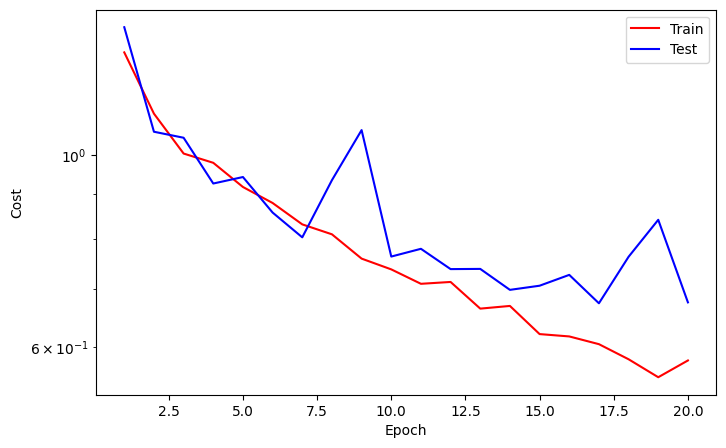

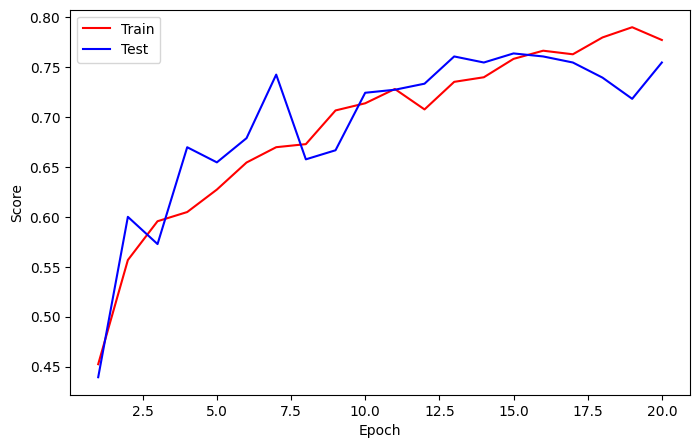

==> EarlyStop patience =  5 | Best test_score: 0.7636

Epoch    21
Train_cost  = 0.5372 | Test_cost  = 0.6460 | Train_score = 0.8006 | Test_score = 0.7758 |

Epoch    22
Train_cost  = 0.5452 | Test_cost  = 0.8146 | Train_score = 0.7883 | Test_score = 0.7364 |
==> EarlyStop patience =  1 | Best test_score: 0.7758

Epoch    23
Train_cost  = 0.5432 | Test_cost  = 0.7111 | Train_score = 0.7996 | Test_score = 0.7515 |
==> EarlyStop patience =  2 | Best test_score: 0.7758

Epoch    24
Train_cost  = 0.5084 | Test_cost  = 0.7796 | Train_score = 0.8083 | Test_score = 0.7606 |
==> EarlyStop patience =  3 | Best test_score: 0.7758

Epoch    25
Train_cost  = 0.5458 | Test_cost  = 0.6504 | Train_score = 0.8011 | Test_score = 0.7758 |
==> EarlyStop patience =  4 | Best test_score: 0.7758

Epoch    26
Train_cost  = 0.4887 | Test_cost  = 0.7246 | Train_score = 0.8078 | Test_score = 0.7455 |
==> EarlyStop patience =  5 | Best test_score: 0.7758

Epoch    27
Train_cost  = 0.4660 | Test_cost  = 0.6559 | 

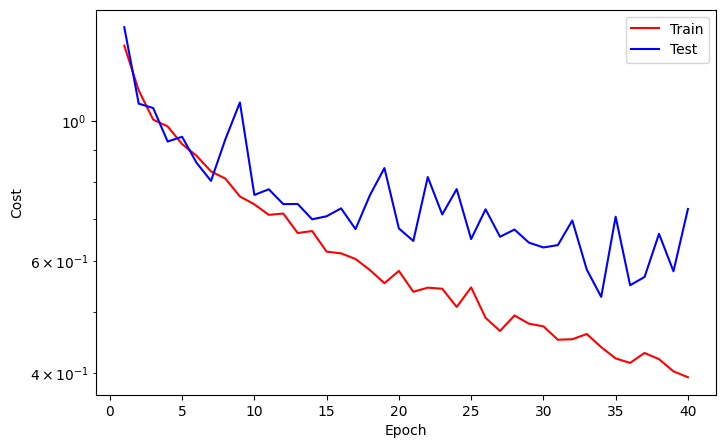

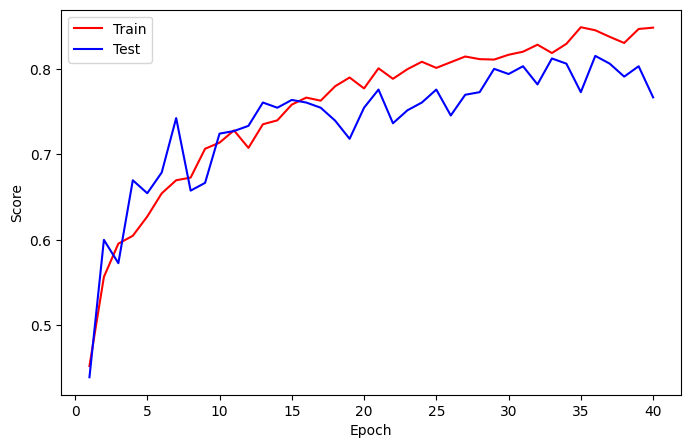

==> EarlyStop patience =  4 | Best test_score: 0.8152

Epoch    41
Train_cost  = 0.4080 | Test_cost  = 0.9075 | Train_score = 0.8482 | Test_score = 0.7394 |
==> EarlyStop patience =  5 | Best test_score: 0.8152

Epoch    42
Train_cost  = 0.4064 | Test_cost  = 0.5698 | Train_score = 0.8507 | Test_score = 0.8242 |

Epoch    43
Train_cost  = 0.3854 | Test_cost  = 0.5548 | Train_score = 0.8538 | Test_score = 0.8121 |
==> EarlyStop patience =  1 | Best test_score: 0.8242

Epoch    44
Train_cost  = 0.3583 | Test_cost  = 1.1054 | Train_score = 0.8594 | Test_score = 0.6727 |
==> EarlyStop patience =  2 | Best test_score: 0.8242

Epoch    45
Train_cost  = 0.4018 | Test_cost  = 0.5930 | Train_score = 0.8451 | Test_score = 0.8121 |
==> EarlyStop patience =  3 | Best test_score: 0.8242

Epoch    46
Train_cost  = 0.3663 | Test_cost  = 0.5457 | Train_score = 0.8655 | Test_score = 0.8273 |

Epoch    47
Train_cost  = 0.3339 | Test_cost  = 0.7351 | Train_score = 0.8809 | Test_score = 0.7606 |
==> Early

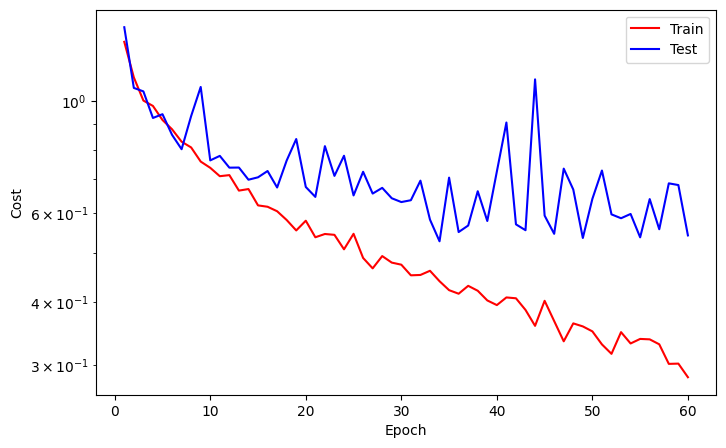

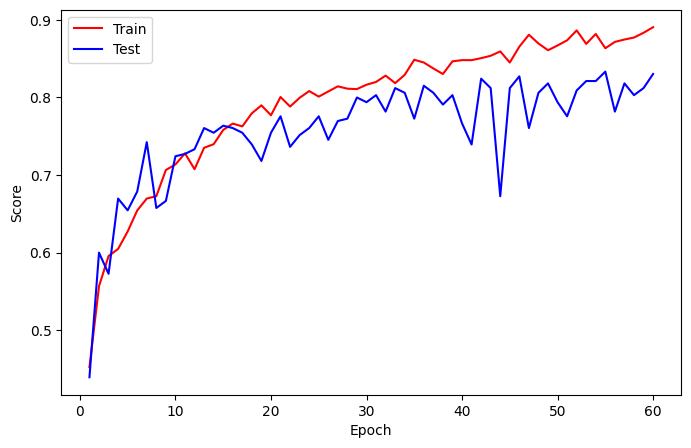

==> EarlyStop patience =  5 | Best test_score: 0.8333

Epoch    61
Train_cost  = 0.2837 | Test_cost  = 0.6278 | Train_score = 0.8942 | Test_score = 0.8121 |
==> EarlyStop patience =  6 | Best test_score: 0.8333

Epoch    62
Train_cost  = 0.2981 | Test_cost  = 0.6643 | Train_score = 0.8891 | Test_score = 0.7879 |
==> EarlyStop patience =  7 | Best test_score: 0.8333

Epoch    63
Train_cost  = 0.3284 | Test_cost  = 0.5585 | Train_score = 0.8732 | Test_score = 0.8091 |
==> EarlyStop patience =  8 | Best test_score: 0.8333

Epoch    64
Train_cost  = 0.2680 | Test_cost  = 0.6077 | Train_score = 0.9039 | Test_score = 0.8273 |
==> EarlyStop patience =  9 | Best test_score: 0.8333

Epoch    65
Train_cost  = 0.2961 | Test_cost  = 0.5929 | Train_score = 0.8804 | Test_score = 0.8394 |

Epoch    66
Train_cost  = 0.2904 | Test_cost  = 0.6749 | Train_score = 0.8967 | Test_score = 0.7939 |
==> EarlyStop patience =  1 | Best test_score: 0.8394

Epoch    67
Train_cost  = 0.2551 | Test_cost  = 0.5870 | 

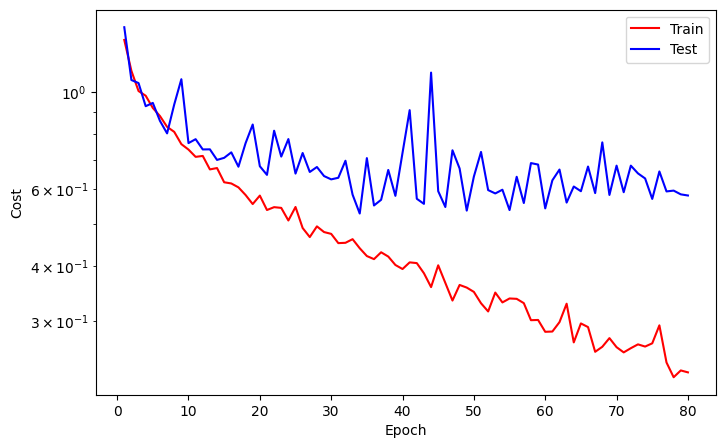

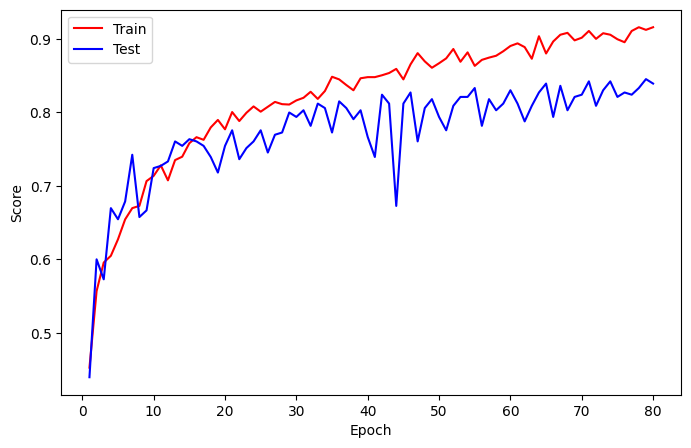

==> EarlyStop patience =  1 | Best test_score: 0.8455

Epoch    81
Train_cost  = 0.2491 | Test_cost  = 0.5890 | Train_score = 0.9136 | Test_score = 0.8061 |
==> EarlyStop patience =  2 | Best test_score: 0.8455

Epoch    82
Train_cost  = 0.2378 | Test_cost  = 0.6896 | Train_score = 0.9192 | Test_score = 0.8333 |
==> EarlyStop patience =  3 | Best test_score: 0.8455

Epoch    83
Train_cost  = 0.2427 | Test_cost  = 0.7695 | Train_score = 0.9054 | Test_score = 0.7939 |
==> EarlyStop patience =  4 | Best test_score: 0.8455

Epoch    84
Train_cost  = 0.2263 | Test_cost  = 0.5953 | Train_score = 0.9233 | Test_score = 0.8061 |
==> EarlyStop patience =  5 | Best test_score: 0.8455

Epoch    85
Train_cost  = 0.2188 | Test_cost  = 0.7638 | Train_score = 0.9213 | Test_score = 0.7818 |
==> EarlyStop patience =  6 | Best test_score: 0.8455

Epoch    86
Train_cost  = 0.2518 | Test_cost  = 0.6997 | Train_score = 0.9034 | Test_score = 0.8273 |
==> EarlyStop patience =  7 | Best test_score: 0.8455

Epo

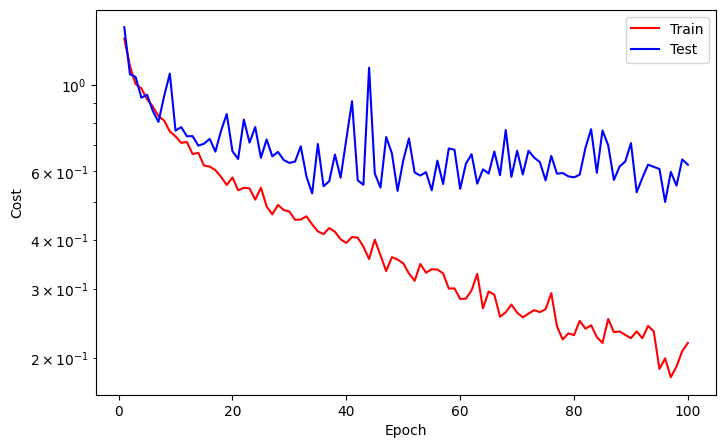

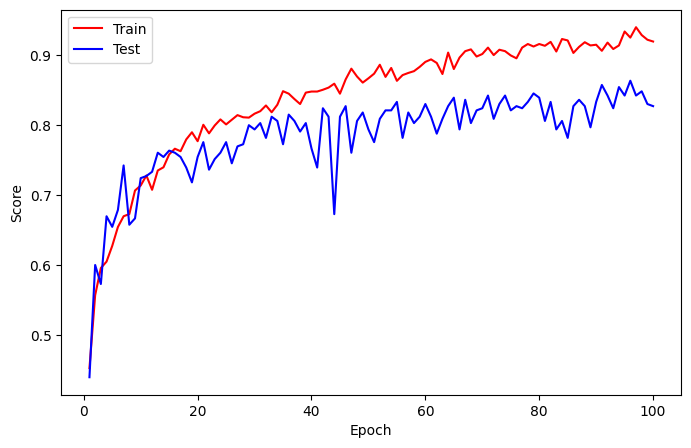

==> EarlyStop patience =  4 | Best test_score: 0.8636

Epoch   101
Train_cost  = 0.1919 | Test_cost  = 0.7247 | Train_score = 0.9284 | Test_score = 0.8212 |
==> EarlyStop patience =  5 | Best test_score: 0.8636

Epoch   102
Train_cost  = 0.2194 | Test_cost  = 0.6117 | Train_score = 0.9243 | Test_score = 0.8576 |
==> EarlyStop patience =  6 | Best test_score: 0.8636

Epoch   103
Train_cost  = 0.1827 | Test_cost  = 0.5664 | Train_score = 0.9346 | Test_score = 0.8364 |
==> EarlyStop patience =  7 | Best test_score: 0.8636

Epoch   104
Train_cost  = 0.1709 | Test_cost  = 0.5010 | Train_score = 0.9387 | Test_score = 0.8848 |

Epoch   105
Train_cost  = 0.1718 | Test_cost  = 0.6692 | Train_score = 0.9387 | Test_score = 0.8212 |
==> EarlyStop patience =  1 | Best test_score: 0.8848

Epoch   106
Train_cost  = 0.1785 | Test_cost  = 0.5498 | Train_score = 0.9300 | Test_score = 0.8576 |
==> EarlyStop patience =  2 | Best test_score: 0.8848

Epoch   107
Train_cost  = 0.2110 | Test_cost  = 0.5226 | 

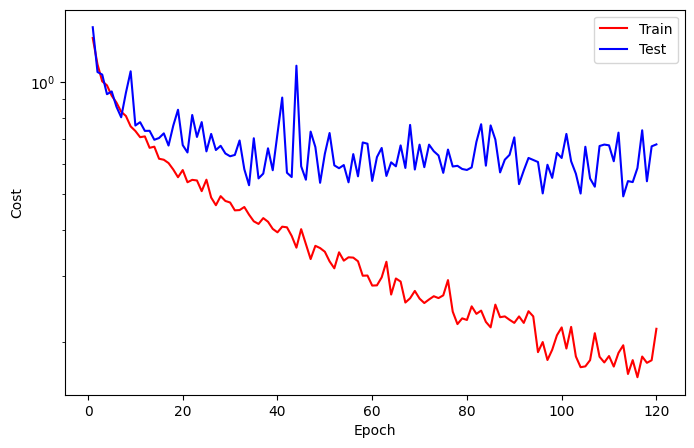

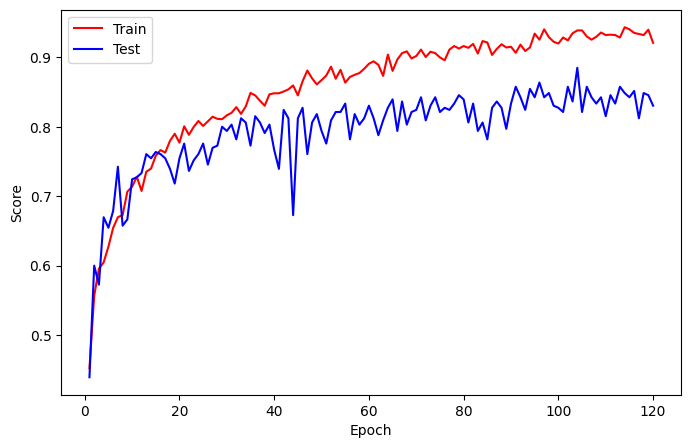

==> EarlyStop patience = 16 | Best test_score: 0.8848

Epoch   121
Train_cost  = 0.1865 | Test_cost  = 0.5079 | Train_score = 0.9294 | Test_score = 0.8636 |
==> EarlyStop patience = 17 | Best test_score: 0.8848

Epoch   122
Train_cost  = 0.1695 | Test_cost  = 0.7570 | Train_score = 0.9335 | Test_score = 0.8394 |
==> EarlyStop patience = 18 | Best test_score: 0.8848

Epoch   123
Train_cost  = 0.1794 | Test_cost  = 0.5203 | Train_score = 0.9361 | Test_score = 0.8515 |
==> EarlyStop patience = 19 | Best test_score: 0.8848

Epoch   124
Train_cost  = 0.1656 | Test_cost  = 0.5582 | Train_score = 0.9427 | Test_score = 0.8515 |
==> EarlyStop patience = 20 | Best test_score: 0.8848

Epoch   125
Train_cost  = 0.1502 | Test_cost  = 0.5420 | Train_score = 0.9438 | Test_score = 0.8636 |
==> EarlyStop patience = 21 | Best test_score: 0.8848

Epoch   126
Train_cost  = 0.1411 | Test_cost  = 0.7228 | Train_score = 0.9571 | Test_score = 0.8394 |
==> EarlyStop patience = 22 | Best test_score: 0.8848

Epo

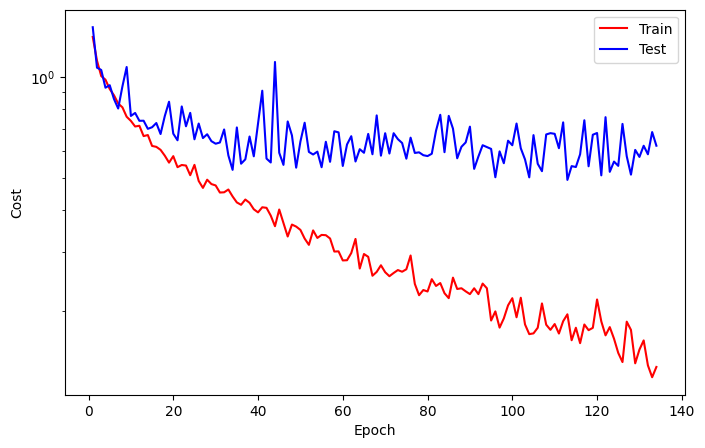

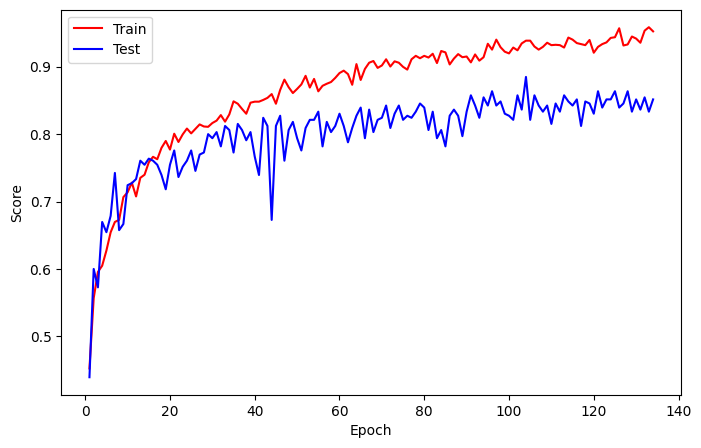

Waktu eksekusi: 3861.0797407627106 detik


In [ ]:
# Catat waktu awal
start_time = time.time()



while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break



# Catat waktu akhir
end_time = time.time()

# Hitung selisih waktu
execution_time = end_time - start_time

print(f"Waktu eksekusi: {execution_time} detik")

## Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([4, 3, 4, 1, 1, 0, 3, 2, 0, 4, 3, 4, 0, 0, 2, 0, 0, 3, 0, 4, 0, 4, 3, 1,
        0, 1, 4, 0, 1, 2, 4, 0, 3, 0, 4, 4, 3, 0, 1, 4, 3, 1, 3, 1, 0, 1, 4, 0,
        0, 4, 3, 4, 0, 4, 4, 4, 0, 4, 2, 4, 1, 0, 1, 1], device='cuda:0')

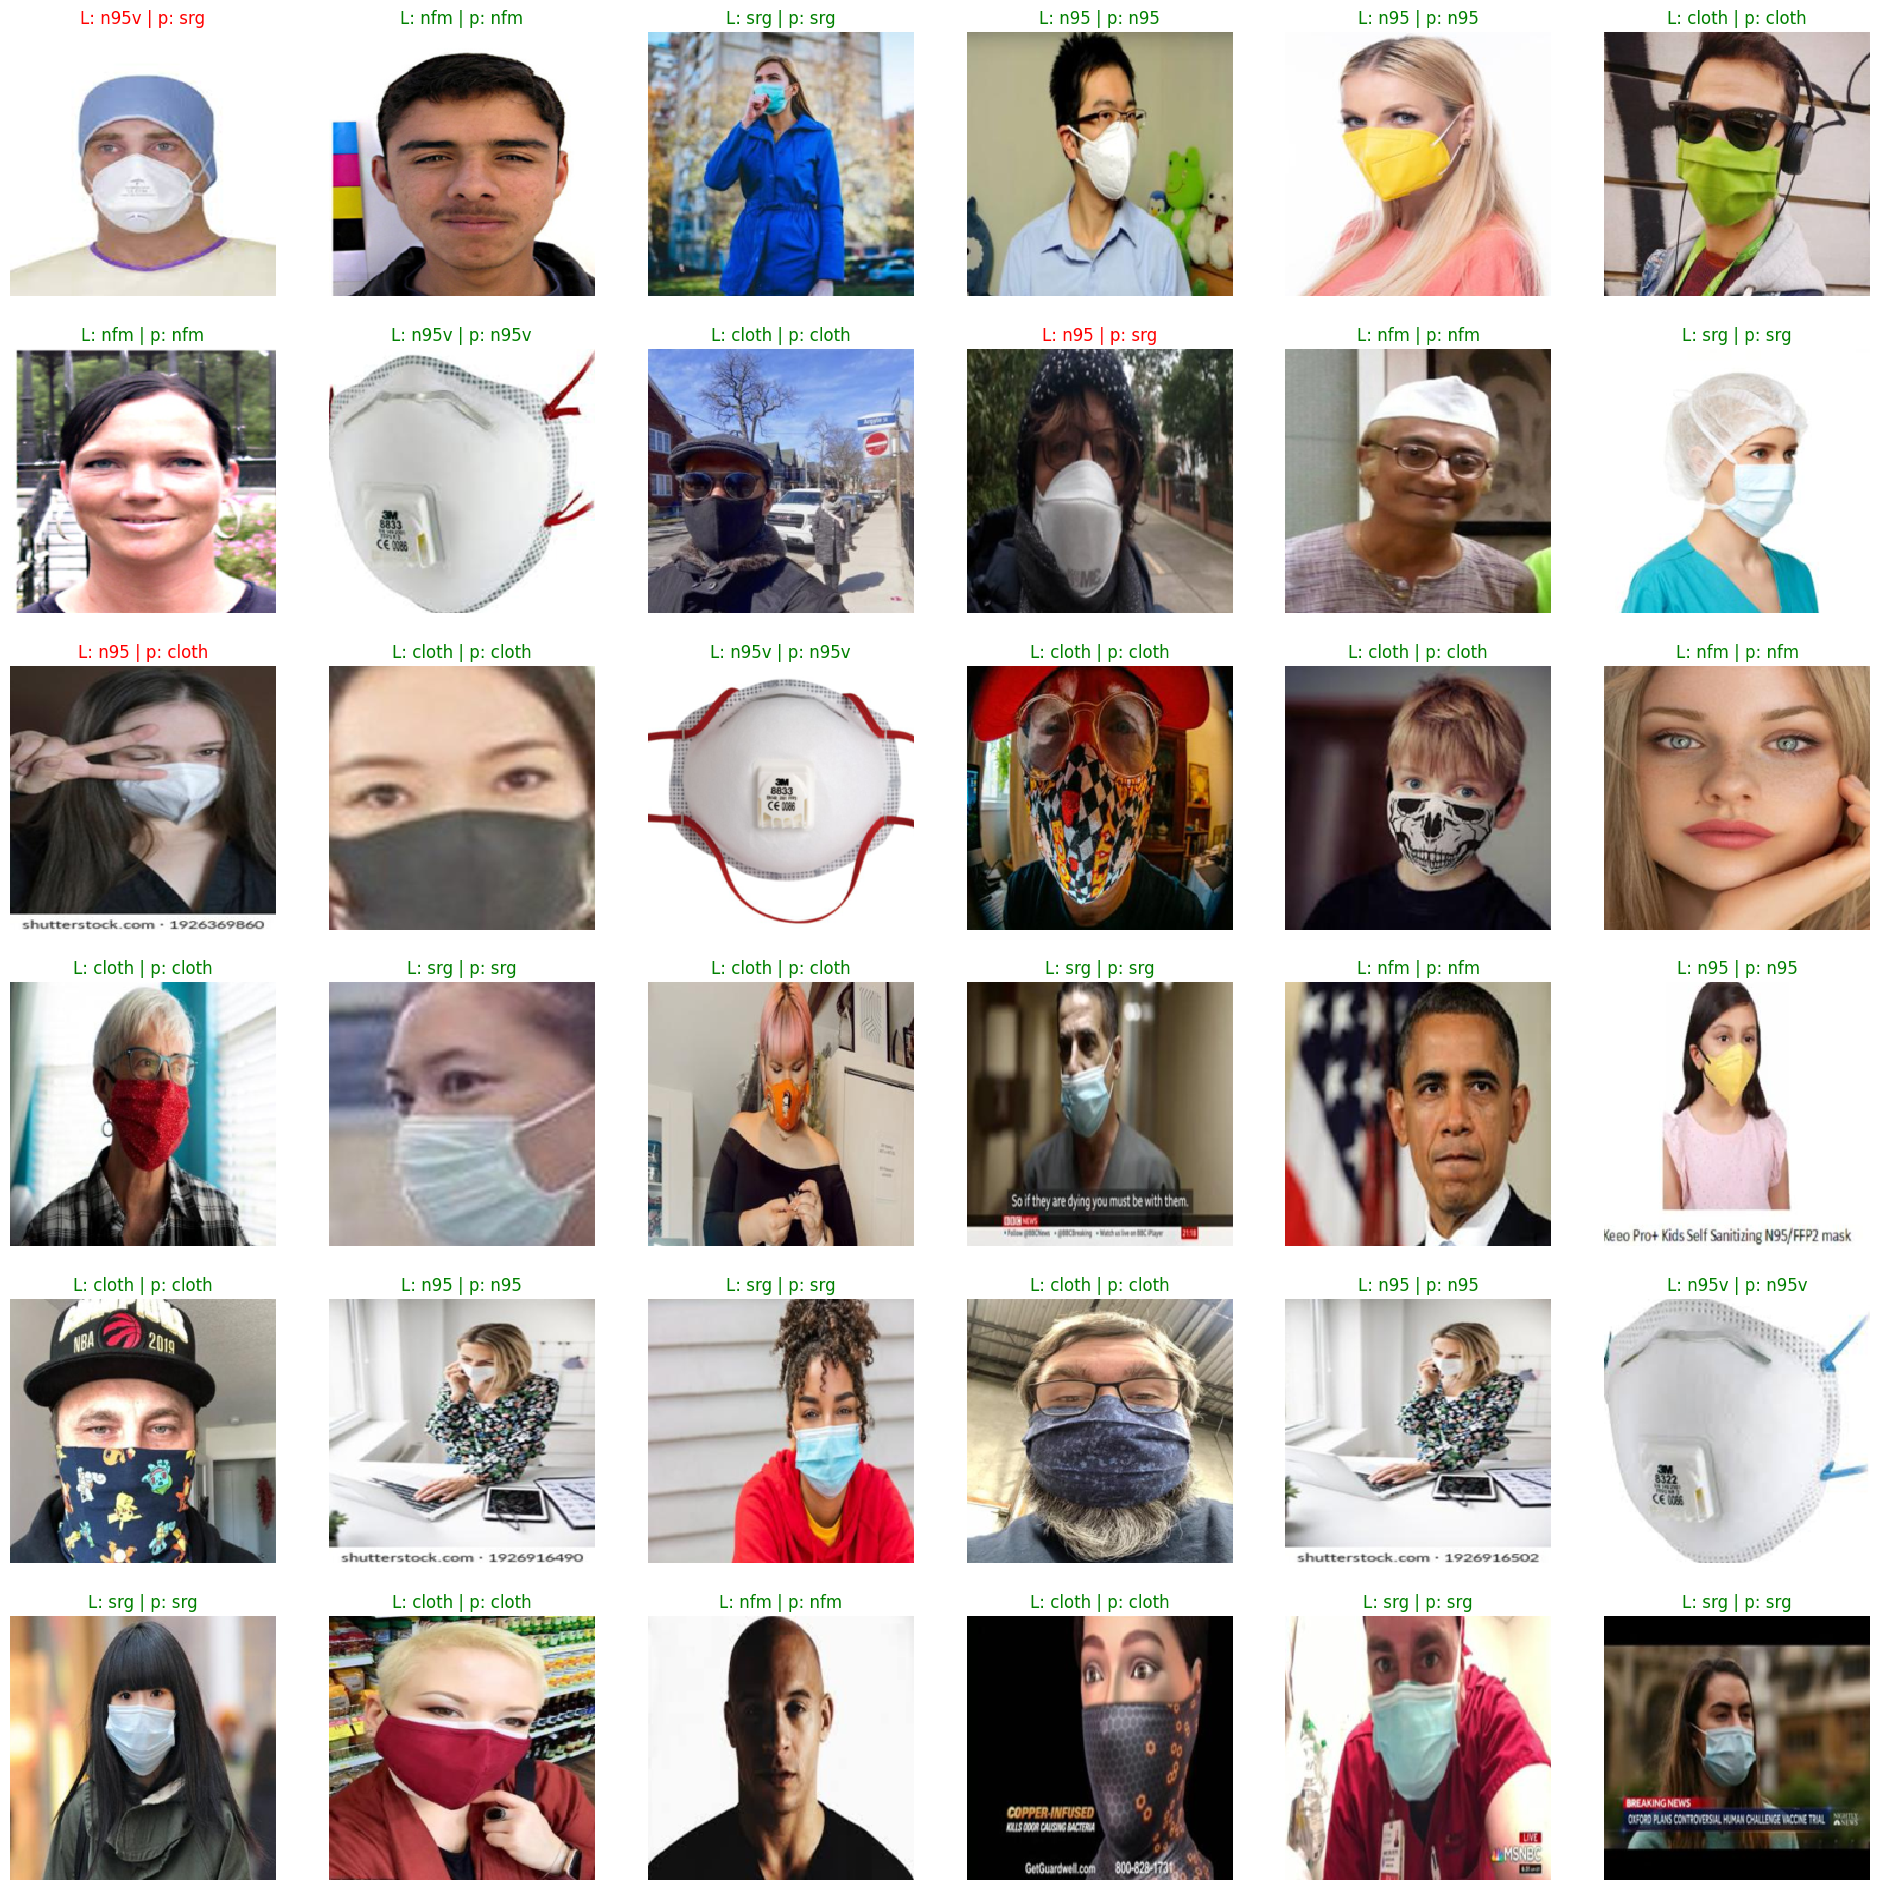

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))  # Mengatur ukuran figure menjadi 24x24

for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    # Mengatur ukuran gambar menjadi 24x24
    ax.imshow(image.permute(1, 2, 0).cpu(), interpolation='nearest', aspect='auto')

    font = {'color': 'r'} if label != pred else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | p: {pred}", fontdict=font)
    ax.axis('off')

plt.show()